In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 115/115 [00:01<00:00, 64.93it/s] 


In [5]:
X_train.shape

(3200, 224, 224, 3)

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [8]:
X_test.shape

(320, 224, 224, 3)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

In [11]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

In [12]:
IMAGE_SIZE = [224, 224]

In [13]:
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in xception.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(xception.output)
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=xception.input, outputs=prediction)

83683744/83683744 [==============================] - 3s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

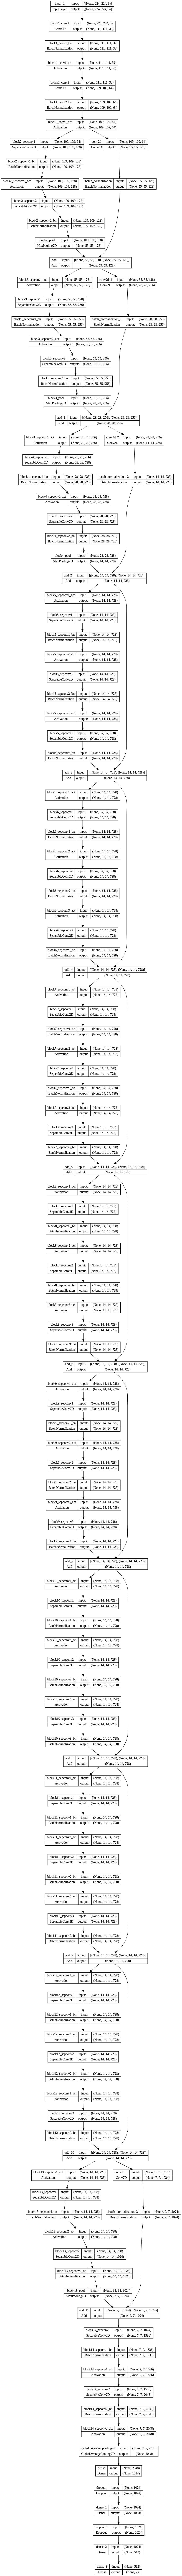

In [14]:
model.summary()

# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='xception.png')

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 7.3869 - accuracy: 0.6767
Epoch 1: val_accuracy improved from -inf to 0.78819, saving model to xception.h5
81/81 [==============================] - 28s 159ms/step - loss: 7.3869 - accuracy: 0.6767 - val_loss: 0.5184 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.7546
Epoch 2: val_accuracy improved from 0.78819 to 0.79861, saving model to xception.h5
81/81 [==============================] - 12s 150ms/step - loss: 0.6824 - accuracy: 0.7546 - val_loss: 0.4875 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7627
Epoch 3: val_accuracy improved from 0.79861 to 0.81250, saving model to xception.h5
81/81 [==============================] - 12s 152ms/step - loss: 0.5662 - accuracy: 0.7627 - val_loss: 0.4736 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/50
81/81 [================

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-18-036bcfb1f050>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


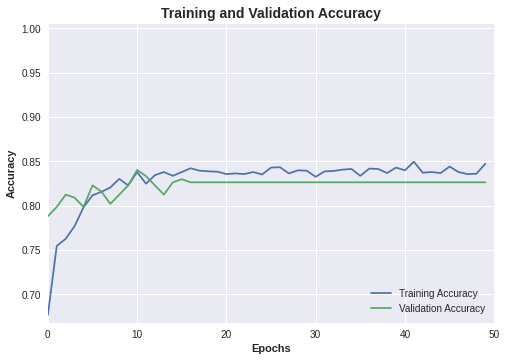

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,50])
plt.ylim([min(plt.ylim()),1.005])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('XceptionTV1',dpi=400)
plt.show()

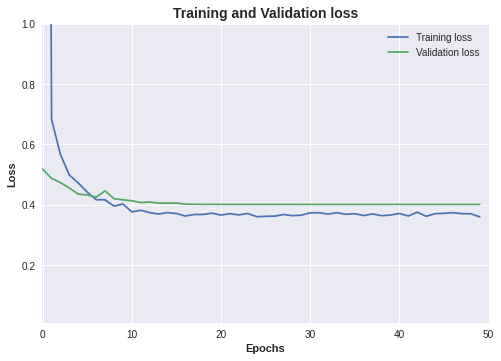

In [20]:
acc = history.history['loss']
val_acc = history.history['val_loss']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Loss',fontweight='bold')
plt.xlim([-0.05,50])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation loss',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('XceptionTV',dpi=400)
plt.show()

In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

10/10 [==============================] - 2s 135ms/step


In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       196
           1       0.86      0.72      0.78       124

    accuracy                           0.84       320
   macro avg       0.85      0.82      0.83       320
weighted avg       0.84      0.84      0.84       320



In [23]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


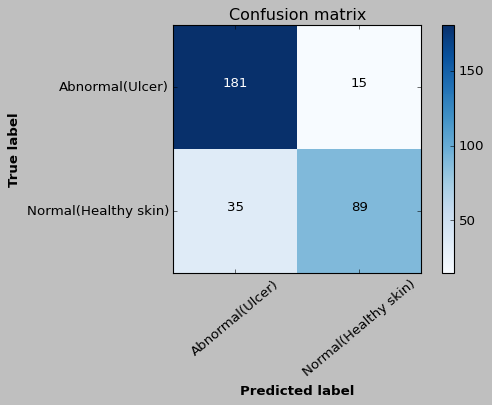

In [24]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues, fontweight='bold'):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(cm,labels)
plt.savefig('XceptionCM',dpi=400)

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.844 Precision: 0.856  Recall: 0.718 F1 Score: 0.781 AUC Score: 0.821


In [26]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [27]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)

Specificity: 0.923


In [28]:
recall=TP/float(TP+FN)
print(' Recall: %.3f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.3f' % precision)

 Recall: 0.718
 Precision: 0.856


In [29]:
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)

F1 Score: 0.78070


In [30]:
print( 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

AUC Score: 0.82061


In [31]:
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))

Error Rate: 0.15625


<ipython-input-32-20cd6bc3a765>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


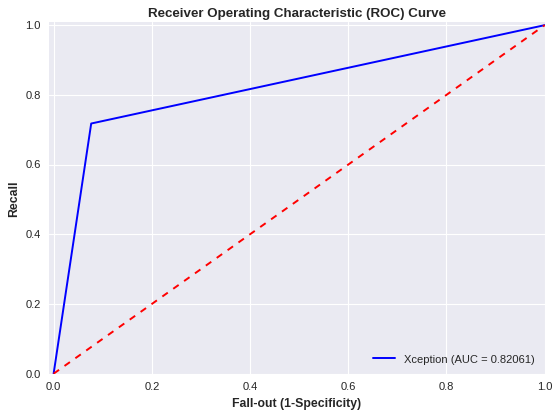

In [32]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'Xception (AUC = %0.5f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('XceptionAUC',dpi=400)
plt.show()

In [33]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 84.38%
Precision: 85.58%
Recall or Sensitivity: 71.77%
Specificity: 92.35%
F1-score: 78.07%
AUC-score: 82.06%
Train acc: 84.72%
